### 1. Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm  
from sklearn.model_selection import GridSearchCV
import joblib

### 2. Read the dataset and show the details

In [2]:
# Load the CSV file
data = pd.read_csv("RFLFSODataFull.csv")

# Print basic information
print("Data Summary:")
print(data.info())  # Gives info about column names, data types, non-null counts


Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  i

In [6]:
# Checking for missing values count
missing_data = data.isnull().sum()

# Display missing data
print(missing_data)
        

FSO_Att                  0
RFL_Att                  0
AbsoluteHumidity         0
AbsoluteHumidityMax      0
AbsoluteHumidityMin      0
Distance                 0
Frequency                0
Particulate              0
ParticulateMax           0
ParticulateMin           0
RainIntensity            0
RainIntensityMax         0
RainIntensityMin         0
RelativeHumidity         0
SYNOPCode                0
Temperature              0
TemperatureDifference    0
TemperatureMax           0
TemperatureMin           0
Time                     0
Visibility               0
VisibilityMax            0
VisibilityMin            0
WindDirection            0
WindSpeed                0
WindSpeedMax             0
WindSpeedMin             0
dtype: int64


### 3. Data preparation


In [3]:
RFL_data = data.drop(columns=['FSO_Att'])
FSO_data = data.drop(columns=['RFL_Att'])

#### 3.1 Specific Model

- Data splitting for specific models (70% training and 30% test sets)

In [4]:
RFL_data = data.drop(columns=['FSO_Att'])
RFL_X = RFL_data.drop(columns=['RFL_Att'])  # Features (drop the target column)
RFL_y = RFL_data['RFL_Att']  # Target column (RFL attenuation)

# Split the data into 80% training and 20% testing
RFL_X_train, RFL_X_test, RFL_y_train, RFL_y_test = train_test_split(RFL_X, RFL_y, test_size=0.3, random_state=4, stratify=RFL_X['SYNOPCode'])

FSO_X = FSO_data.drop(columns=['FSO_Att'])
FSO_y = FSO_data['FSO_Att']
FSO_X_train, FSO_X_test, FSO_y_train, FSO_y_test = train_test_split(FSO_X, FSO_y, test_size=0.3, random_state=42, stratify=RFL_X['SYNOPCode'])

# Verify the split
print("RFL Training set size:", RFL_X_train.shape)
print("RFL Test set size:", RFL_X_test.shape)
print("FSO Training set size:", FSO_X_train.shape)
print("FSO Test set size:", FSO_X_test.shape)



RFL Training set size: (63965, 25)
RFL Test set size: (27414, 25)
FSO Training set size: (63965, 25)
FSO Test set size: (27414, 25)


- Preparing data subsets based on weather conditions for specific model 

In [5]:
# Group RFL_X_train and RFL_y_train based on SYNOPCode
RFL_X_train_groups = [RFL_X_train[RFL_X_train['SYNOPCode'] == code].drop(columns=['SYNOPCode']) for code in [0, 3, 4, 5, 6, 7, 8]]
RFL_y_train_groups = [RFL_y_train[RFL_X_train['SYNOPCode'] == code] for code in [0, 3, 4, 5, 6, 7, 8]]

# Export each group to CSV
for code, X_group, y_group in zip([0, 3, 4, 5, 6, 7, 8], RFL_X_train_groups, RFL_y_train_groups):
    X_group.to_csv(f'RFL_X_train_SYNOPCode_{code}.csv', index=False)
    y_group.to_csv(f'RFL_y_train_SYNOPCode_{code}.csv', index=False)
    
# Group FSO_X_train and FSO_y_train based on SYNOPCode
FSO_X_train_groups = [FSO_X_train[FSO_X_train['SYNOPCode'] == code].drop(columns=['SYNOPCode']) for code in [0, 3, 4, 5, 6, 7, 8]]
FSO_y_train_groups = [FSO_y_train[FSO_X_train['SYNOPCode'] == code] for code in [0, 3, 4, 5, 6, 7, 8]]

# Export each group to CSV
for code, X_group, y_group in zip([0, 3, 4, 5, 6, 7, 8], FSO_X_train_groups, FSO_y_train_groups):
    X_group.to_csv(f'FSO_X_train_SYNOPCode_{code}.csv', index=False)
    y_group.to_csv(f'FSO_y_train_SYNOPCode_{code}.csv', index=False)

#### 3.2 Generic Model

- Data preparing for generic models (70% training and 30% test sets)

In [11]:
# Apply one-hot encoding and ensure the output is integers (0 and 1)
RFL_X_train_generic = pd.get_dummies(RFL_X_train, columns=['SYNOPCode'], prefix='SYNOP', drop_first=True).astype(int)
RFL_X_test_generic = pd.get_dummies(RFL_X_test, columns=['SYNOPCode'], prefix='SYNOP', drop_first=True).astype(int)
FSO_X_train_generic = pd.get_dummies(FSO_X_train, columns=['SYNOPCode'], prefix='SYNOP', drop_first=True).astype(int)
FSO_X_test_generic = pd.get_dummies(FSO_X_test, columns=['SYNOPCode'], prefix='SYNOP', drop_first=True).astype(int)

# Targets remain unchanged
RFL_y_train_generic = RFL_y_train
RFL_y_test_generic = RFL_y_test
FSO_y_train_generic = FSO_y_train
FSO_y_test_generic = FSO_y_test

# Verify the split
print("Training set size:", RFL_X_train_generic.shape)
print("Test set size:", RFL_X_test_generic.shape)
print("Training set size:", FSO_X_train_generic.shape)
print("Test set size:", FSO_X_test_generic.shape)

Training set size: (63965, 30)
Test set size: (27414, 30)
Training set size: (63965, 30)
Test set size: (27414, 30)


### 3.3 Plotting the bar chart for the SYNOPCode distribution

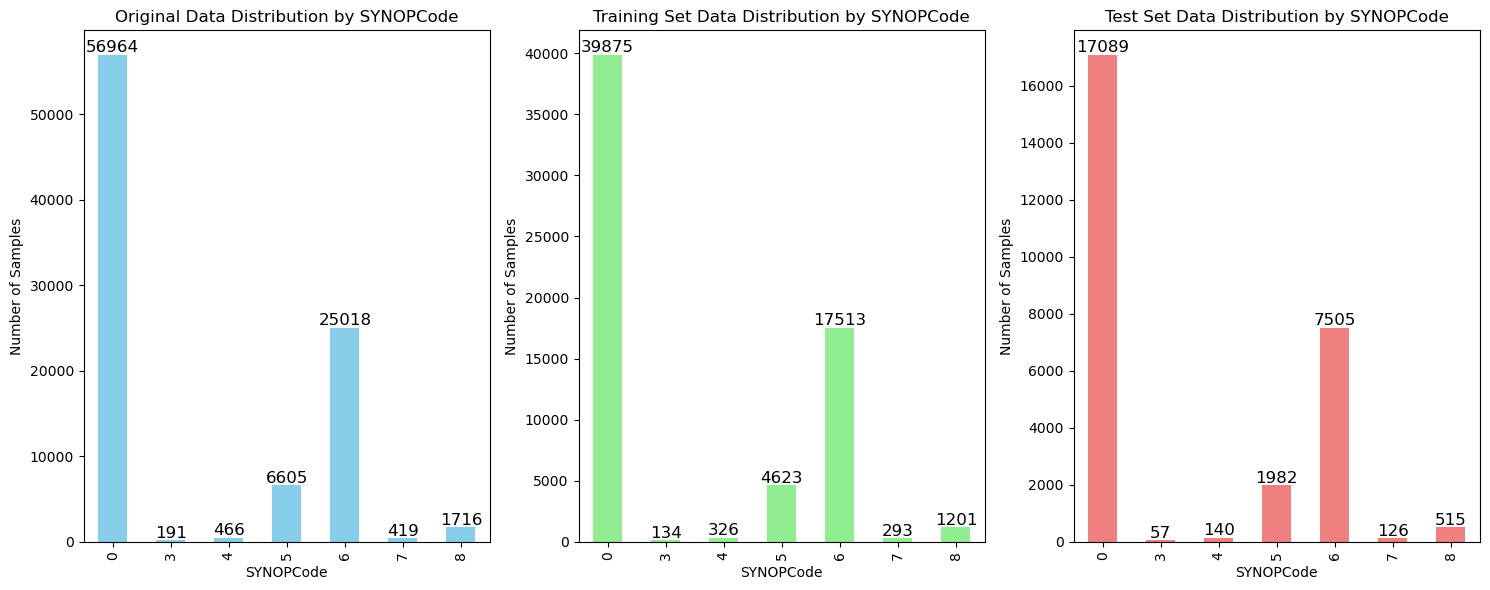

In [9]:
# Define the order for SYNOPCode (ordinal order)
synop_code_order = [0, 3, 4, 5, 6, 7, 8]


# Plot for RFL data (original dataset, training set, and test set)
plt.figure(figsize=(15, 6))

# Get counts for each SYNOPCode
RFL_code_counts = data['SYNOPCode'].value_counts().reindex(synop_code_order, fill_value=0)
RFL_train_code_counts = RFL_X_train['SYNOPCode'].value_counts().reindex(synop_code_order, fill_value=0)
RFL_test_code_counts = RFL_X_test['SYNOPCode'].value_counts().reindex(synop_code_order, fill_value=0)

# Create subplots for original, training, and test data distributions
plt.subplot(1, 3, 1)
ax1 = RFL_code_counts.plot(kind='bar', color='skyblue')
plt.title("Original Data Distribution by SYNOPCode")
plt.xlabel("SYNOPCode")
plt.ylabel("Number of Samples")
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.subplot(1, 3, 2)
ax2 = RFL_train_code_counts.plot(kind='bar', color='lightgreen')
plt.title("Training Set Data Distribution by SYNOPCode")
plt.xlabel("SYNOPCode")
plt.ylabel("Number of Samples")
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.subplot(1, 3, 3)
ax3 = RFL_test_code_counts.plot(kind='bar', color='lightcoral')
plt.title("Test Set Data Distribution by SYNOPCode")
plt.xlabel("SYNOPCode")
plt.ylabel("Number of Samples")
for p in ax3.patches:
    ax3.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()

### 4. Feature Elemination Function

In [6]:
def iterative_feature_elimination(X_train, y_train, channel_name):
    n_features = X_train.shape[1]
    feature_names = list(X_train.columns)
    
    # Store the history for RMSE, R^2, and deleted features for each iteration
    history = []

    # Progress bar setup using tqdm
    with tqdm(total=n_features, desc=f'Eliminating features for {channel_name}', unit='feature') as pbar:
        for i in range(n_features, 0, -1):
            # Initialize the Random Forest with OOB score enabled
            rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state= 42)
            rf.fit(X_train, y_train)

            # Calculate RMSE and R^2
            oob_predictions = rf.oob_prediction_
            rmse = np.sqrt(mean_squared_error(y_train, oob_predictions))
            r2 = r2_score(y_train, oob_predictions)

            # Identify the least important feature
            feature_importances = rf.feature_importances_
            least_important_feature = feature_names[np.argmin(feature_importances)]

            # Store the results in history, including the deleted feature
            history.append({
                'features_left': i,
                'rmse': rmse,
                'r2': r2,
                'deleted_feature': least_important_feature,
                'remaining_features': feature_names.copy()
            })

            # Remove the least important feature
            if i > 1:
                X_train = X_train.drop(columns=[least_important_feature])
                feature_names.remove(least_important_feature)

            # Update the progress bar
            pbar.update(1)

    # Return the history for this channel
    return history


#### 4.1 Plotting feature importance graph (with green line) for specific model

In [7]:
def plot_feature_elimination(history, synop_code, stop_feature, name):
    # Map SYNOPCode to weather conditions
    weather_conditions = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Shower'
    }

    # Get the weather condition for the SYNOPCode
    weather_condition = weather_conditions.get(synop_code, "Unknown Weather Condition")
    
    features_removed = [entry['deleted_feature'] for entry in history]
    rmse_values = [entry['rmse'] for entry in history]
    r2_values = [entry['r2'] for entry in history]


    # Plot RMSE and R²
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Features Removed (Least Important → Most Important)')
    ax1.set_ylabel('RMSE (dB)', color='blue')
    ax1.plot(features_removed, rmse_values, color='blue', label='RMSE', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('R-squared', color='orange')
    ax2.plot(features_removed, r2_values, color='orange', label='R-squared', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='orange')

    # Adding feature names to x-axis (only one feature per iteration)
    ax1.set_xticks(range(len(features_removed)))
    ax1.set_xticklabels(features_removed, rotation=90)

    # Title with updated description, now using the weather condition
    plt.title(f'{name} model performance ({weather_condition}) - SYNOPCode {synop_code}')

    # Add green dotted line at specified feature if not None
    if stop_feature is not None and stop_feature in features_removed:
        stop_index = features_removed.index(stop_feature)
        ax1.axvline(x=stop_index, color='green', linestyle='--', linewidth=2, label='Recommended Stop')

    # Display the plot
    fig.tight_layout()
    plt.show()


In [8]:
# Get the features_left, rmse, r2, and remaining_features after finding the stop feature
def get_details_after_stop_feature(histories, stop_features, channel_name):

    result = {}
    for synop_code, stop_feature in stop_features.items():
        history_key = f'{channel_name}_SYNOPCode_{synop_code}_history'
        history = histories.get(history_key, [])
        if stop_feature is None:
            # Return the first entry if stop feature is None
            if history:
                result[history_key] = {
                    'features_left': history[0]['features_left'],
                    'rmse': history[0]['rmse'],
                    'r2': history[0]['r2'],
                    'remaining_features': history[0]['remaining_features'],
                }
            else:
                result[history_key] = "History is empty."
        else:
            # Find the entry after the stop feature
            for i, entry in enumerate(history):
                if entry['deleted_feature'] == stop_feature:
                    # Check if there is a next entry in the history
                    if i + 1 < len(history):
                        next_entry = history[i + 1]
                        result[history_key] = {
                            'features_left': next_entry['features_left'],
                            'rmse': next_entry['rmse'],
                            'r2': next_entry['r2'],
                            'remaining_features': next_entry['remaining_features'],
                        }
                    else:
                        result[history_key] = "Stop feature is the last deleted feature."
                    break
            else:
                result[history_key] = "Stop feature not found in the history."
    return result


#### 4.2 Plotting feature importance graph (with green line) for generic model

In [9]:
def plot_feature_elimination_generic(history, stop_feature, channel_name):
    
    features_removed = [entry['deleted_feature'] for entry in history]
    rmse_values = [entry['rmse'] for entry in history]
    r2_values = [entry['r2'] for entry in history]


    # Plot RMSE and R²
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Features Removed (Least Important → Most Important)')
    ax1.set_ylabel('RMSE (dB)', color='blue')
    ax1.plot(features_removed, rmse_values, color='blue', label='RMSE', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('R-squared', color='orange')
    ax2.plot(features_removed, r2_values, color='orange', label='R-squared', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='orange')

    # Adding feature names to x-axis (only one feature per iteration)
    ax1.set_xticks(range(len(features_removed)))
    ax1.set_xticklabels(features_removed, rotation=90)

    # Title with updated description, now using the weather condition
    plt.title(f'{channel_name} generic model performance')

    # Add green dotted line at specified feature if not None
    if stop_feature is not None and stop_feature in features_removed:
        stop_index = features_removed.index(stop_feature)
        ax1.axvline(x=stop_index, color='green', linestyle='--', linewidth=2, label='Recommended Stop')

    # Display the plot
    fig.tight_layout()
    plt.show()




In [11]:
# Get the features_left, rmse, r2, and remaining_features after finding the stop feature
def get_details_after_stop_feature_generic(history, stop_feature):

    if not history:
        return {"Error": "Generic history is empty."}

    if stop_feature is None:
        # Return the first entry if no stop feature is provided
        return {
            'features_left': history[0]['features_left'],
            'rmse': history[0]['rmse'],
            'r2': history[0]['r2'],
            'remaining_features': history[0]['remaining_features'],
        }

    # Find the entry after the stop feature
    for i, entry in enumerate(history):
        if entry['deleted_feature'] == stop_feature:
            if i + 1 < len(history):
                next_entry = history[i + 1]
                return {
                    'features_left': next_entry['features_left'],
                    'rmse': next_entry['rmse'],
                    'r2': next_entry['r2'],
                    'remaining_features': next_entry['remaining_features'],
                }
            else:
                return {"Error": "Stop feature is the last deleted feature."}

    return {"Error": "Stop feature not found in the history."}


### 5. Hyperparameter function

#### 5.1 Specific Models

In [100]:
def hyperparameter_tuning_for_specific_models(X_train_groups, y_train_groups, stop_features, synop_codes, channel_name):
    best_models = {}

    # Define the hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
    }

    for i, synop_code in enumerate(tqdm(synop_codes, desc='Hyperparameter tuning')):
        X_train = X_train_groups[i].copy()
        y_train = y_train_groups[i].copy()

        stop_feature = stop_features[synop_code]

        # Get the history for the current SYNOPCode
        history_source = f'{channel_name}_histories'
        history = globals()[history_source][f'{channel_name}_SYNOPCode_{synop_code}_history']

        # Select features based on the history, excluding the stop feature
        selected_features = X_train.columns.tolist()
        if stop_feature in selected_features:
            selected_features.remove(stop_feature)

        # Select only the relevant features
        X_train = X_train[selected_features]

        # Initialize the RandomForestRegressor
        rf = RandomForestRegressor(oob_score=True, random_state=42)

        # Perform Grid Search for hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=rf, 
            param_grid=param_grid, 
            cv=3, 
            n_jobs=-1, 
            verbose=1,  # Use verbose to track progress instead of tqdm
            scoring='neg_mean_squared_error'
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Best model and parameters after tuning
        best_rf_model = grid_search.best_estimator_

        # Evaluate the best model with OOB score
        oob_rmse = np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train)))
        oob_r2 = r2_score(y_train, best_rf_model.predict(X_train))

        # Store the best model, hyperparameters, and performance metrics
        best_models[synop_code] = {
            'best_model': best_rf_model,
            'best_params': grid_search.best_params_,
            'oob_rmse': oob_rmse,
            'oob_r2': oob_r2,
            'features': selected_features  
        }

        # Save the best model
        joblib.dump(best_rf_model, f'{channel_name}_SYNOPCode_{synop_code}_best_model.pkl')

        print(f"Best Model for SYNOPCode {synop_code}:")
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"OOB RMSE: {oob_rmse:.4f}")
        print(f"OOB R^2: {oob_r2:.4f}")

    return best_models


#### 5.2 Generic Models

In [18]:
def hyperparameter_tuning_generic_model(X_train, y_train, selected_features, channel_name):
    # Define the hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
    print(selected_features)
    
    # Select only the relevant features
    X_train = X_train[selected_features]

    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(oob_score=True, random_state=42)

    # Perform Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
    
    grid_search.fit(X_train, y_train)

    # Best model and parameters after tuning
    best_rf_model = grid_search.best_estimator_

    # Evaluate the best model with OOB score
    oob_rmse = np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train)))
    oob_r2 = r2_score(y_train, best_rf_model.predict(X_train))

    # Store the best model, hyperparameters, and performance metrics
    best_model_data = {
        'best_model': best_rf_model,
        'best_params': grid_search.best_params_,
        'oob_rmse': oob_rmse,
        'oob_r2': oob_r2,
        'features': selected_features  
    }

    # Save the best model
    joblib.dump(best_rf_model, f'{channel_name}_best_model.pkl')

    print("Best Model:")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"OOB RMSE: {oob_rmse:.4f}")
    print(f"OOB R^2: {oob_r2:.4f}")

    return best_model_data


### 6. Evaluation on Test Set Function

#### 6.1 Specific Models

In [13]:
def evaluate_specific_models(models, X_test, y_test):
    """
    Evaluate a dictionary of models using the specified test dataset.

    Parameters:
        models (dict): Dictionary where keys are SYNOPCodes, and values contain model details.
        X_test (DataFrame): Test dataset including SYNOPCode and all features.
        y_test (DataFrame or Series): Target values for the test set.

    Returns:
        overall_rmse (list): List of RMSE for each SYNOPCode model.
        overall_r2 (list): List of R^2 for each SYNOPCode model.
        overall_rmse_mean (float): Mean RMSE across all models.
        overall_r2_mean (float): Mean R^2 across all models.
    """
    overall_rmse = []
    overall_r2 = []

    for synop_code, model_info in models.items():
        # Filter X_test and y_test for the current SYNOPCode
        X_test_synop = X_test[X_test['SYNOPCode'] == synop_code].drop(columns=['SYNOPCode'])
        y_test_synop = y_test[X_test['SYNOPCode'] == synop_code]

        # Get the model and features
        model = model_info['best_model']
        selected_features = model_info['features']

        # Ensure we only use the selected features for prediction
        X_test_selected = X_test_synop[selected_features]

        # Make predictions
        y_pred = model.predict(X_test_selected)

        # Calculate RMSE and R^2
        rmse = np.sqrt(mean_squared_error(y_test_synop, y_pred))
        r2 = r2_score(y_test_synop, y_pred)

        overall_rmse.append(rmse)
        overall_r2.append(r2)

        print(f'Model evaluation for SYNOPCode {synop_code}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}')

    # Calculate overall metrics
    overall_rmse_mean = np.mean(overall_rmse)
    overall_r2_mean = np.mean(overall_r2)

    print(f'Overall RMSE for all models: {overall_rmse_mean:.4f}')
    print(f'Overall R^2 for all models: {overall_r2_mean:.4f}')

    return overall_rmse, overall_r2, overall_rmse_mean, overall_r2_mean


#### 6.2 Generic Models

In [20]:
def evaluate_generic_model(model, X_test, y_test, drop_first_columns, selected_features):
    
    # Extract optimal features from the history
    optimal_features = selected_features
    
    # Add back SYNOPCode_0 to one-hot encoded features
    X_test['SYNOP_0'] = (X_test[drop_first_columns].sum(axis=1) == 0).astype(int)

    # Add SYNOPCode_0 to the list of columns for evaluation
    all_synop_columns = ['SYNOP_0'] + drop_first_columns

    results = {}

    # Lists to store all predictions and actual values for overall metrics
    all_preds = []
    all_actuals = []

    for synop_col in all_synop_columns:
        # Filter test data for the current SYNOPCode
        X_test_synop = X_test[X_test[synop_col] == 1]
        y_test_synop = y_test[X_test[synop_col] == 1]
        
        if len(X_test_synop) == 0:
            # Skip if no data points belong to this SYNOPCode
            continue
        
        # Ensure only the optimal features are selected
        X_test_synop_optimal = X_test_synop[optimal_features]
        
        # Align the test set features with the model’s feature order
        X_test_aligned = X_test_synop_optimal[model.feature_names_in_]

        # Make predictions
        y_pred = model.predict(X_test_aligned)
        
        # Append predictions and actual values to overall lists
        all_preds.extend(y_pred)
        all_actuals.extend(y_test_synop)
        
        # Calculate RMSE and R^2 for the current SYNOPCode
        rmse = np.sqrt(mean_squared_error(y_test_synop, y_pred))
        r2 = r2_score(y_test_synop, y_pred)
        
        # Store the results for this SYNOPCode
        results[synop_col] = {'RMSE': rmse, 'R^2': r2}

        print(f"{synop_col}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")
    
    # Calculate overall RMSE and R^2
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
    overall_r2 = r2_score(all_actuals, all_preds)
    
    # Print and store overall metrics
    print(f"Overall: RMSE = {overall_rmse:.4f}, R^2 = {overall_r2:.4f}")
    results['Overall'] = {'RMSE': overall_rmse, 'R^2': overall_r2}
    
    return results


### 7. Function for Model Comparison 
- Plotting rmse and rsq of specific models and generic models based on weather conditions

In [22]:
def plot_rmse_rsq_comparison(weather_conditions, rf_specific_rmse, rf_specific_r2, fso_specific_rmse, fso_specific_r2, rf_generic_results, fso_generic_results):
    # Extract weather condition names for x-axis labels
    synop_codes = list(weather_conditions.keys())
    weather_labels = [weather_conditions[code] for code in synop_codes]
    
    # Prepare RMSE data
    rf_generic_rmse = [rf_generic_results[f'SYNOP_{code}']['RMSE'] for code in synop_codes]
    fso_generic_rmse = [fso_generic_results[f'SYNOP_{code}']['RMSE'] for code in synop_codes]

    # Prepare R² data
    rf_generic_r2 = [rf_generic_results[f'SYNOP_{code}']['R^2'] for code in synop_codes]
    fso_generic_r2 = [fso_generic_results[f'SYNOP_{code}']['R^2'] for code in synop_codes]
    
    # Plot RMSE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_title("RMSE Comparison by Weather Condition")
    ax1.set_xlabel("Weather Condition")
    ax1.set_ylabel("RMSE")
    # Specific models with solid lines
    ax1.plot(weather_labels, rf_specific_rmse, label="RF Specific RMSE", color='blue', marker='o', linestyle='-')
    ax1.plot(weather_labels, fso_specific_rmse, label="FSO Specific RMSE", color='red', marker='o', linestyle='-')
    # Generic models with dotted lines
    ax1.plot(weather_labels, rf_generic_rmse, label="RF Generic RMSE", color='blue', marker='x', linestyle=':')
    ax1.plot(weather_labels, fso_generic_rmse, label="FSO Generic RMSE", color='red', marker='x', linestyle=':')
    ax1.legend(loc="upper right")
    
    # Plot R²
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.set_title("R² Comparison by Weather Condition")
    ax2.set_xlabel("Weather Condition")
    ax2.set_ylabel("R²")
    # Specific models with solid lines
    ax2.plot(weather_labels, rf_specific_r2, label="RF Specific R²", color='blue', marker='o', linestyle='-')
    ax2.plot(weather_labels, fso_specific_r2, label="FSO Specific R²", color='red', marker='o', linestyle='-')
    # Generic models with dotted lines
    ax2.plot(weather_labels, rf_generic_r2, label="RF Generic R²", color='blue', marker='x', linestyle=':')
    ax2.plot(weather_labels, fso_generic_r2, label="FSO Generic R²", color='red', marker='x', linestyle=':')
    ax2.legend(loc="lower left")

    # Display both plots
    plt.tight_layout()
    plt.show()


### 8. Modeling

#### 8.1 RF Specific Model 

In [ ]:
# Feature Elemination For RF Specific Model 
RFL_histories = {}
for code, X_group, y_group in zip([0, 3, 4, 5, 6, 7, 8], RFL_X_train_groups, RFL_y_train_groups):
    RFL_histories[f'RFL_SYNOPCode_{code}_history'] = iterative_feature_elimination(X_group, y_group, f'RFL_SYNOPCode_{code}')

Eliminating features for RFL_SYNOPCode_8: 100%|██████████| 24/24 [00:27<00:00,  1.13s/feature]


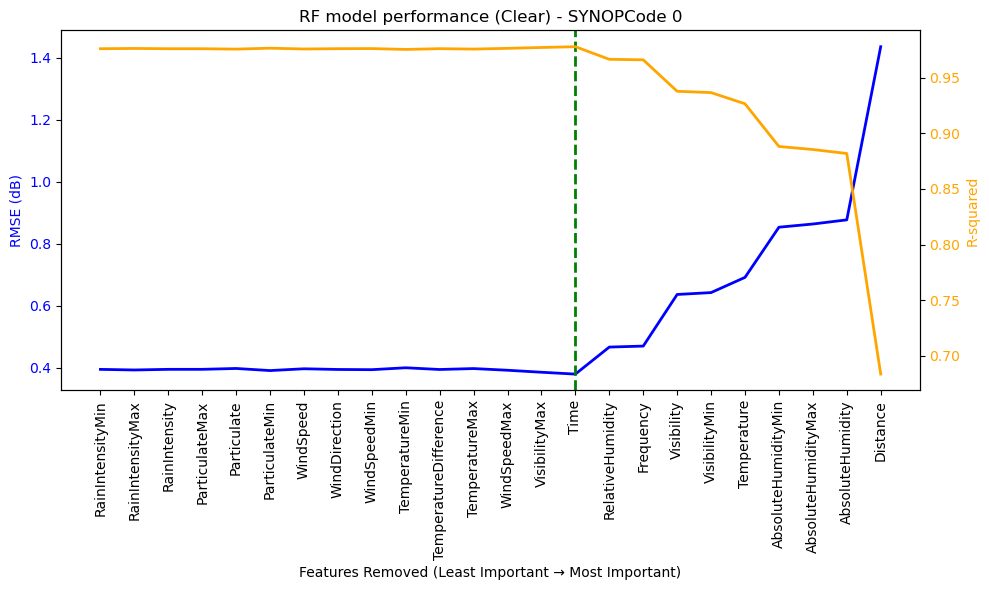

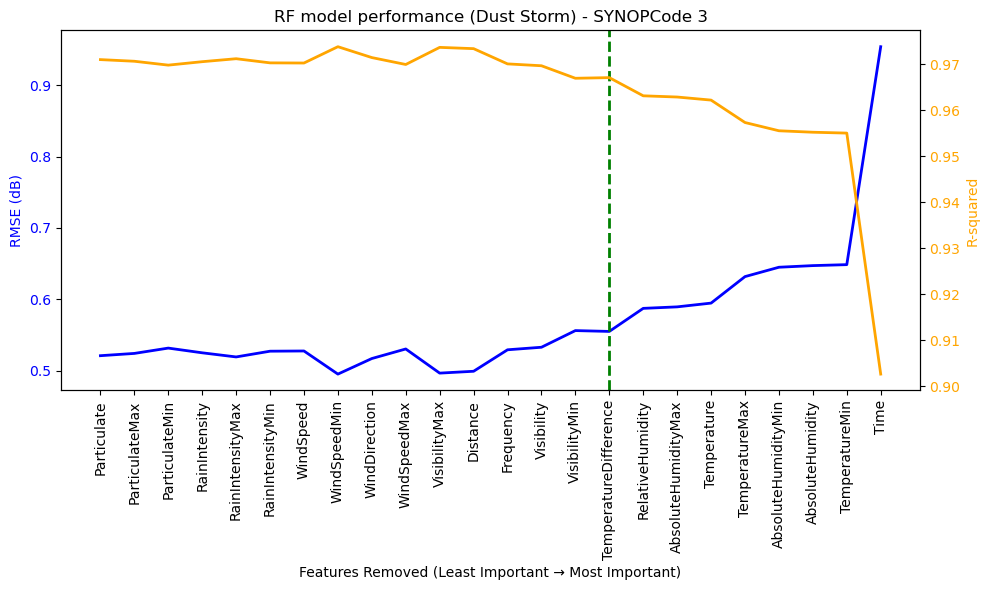

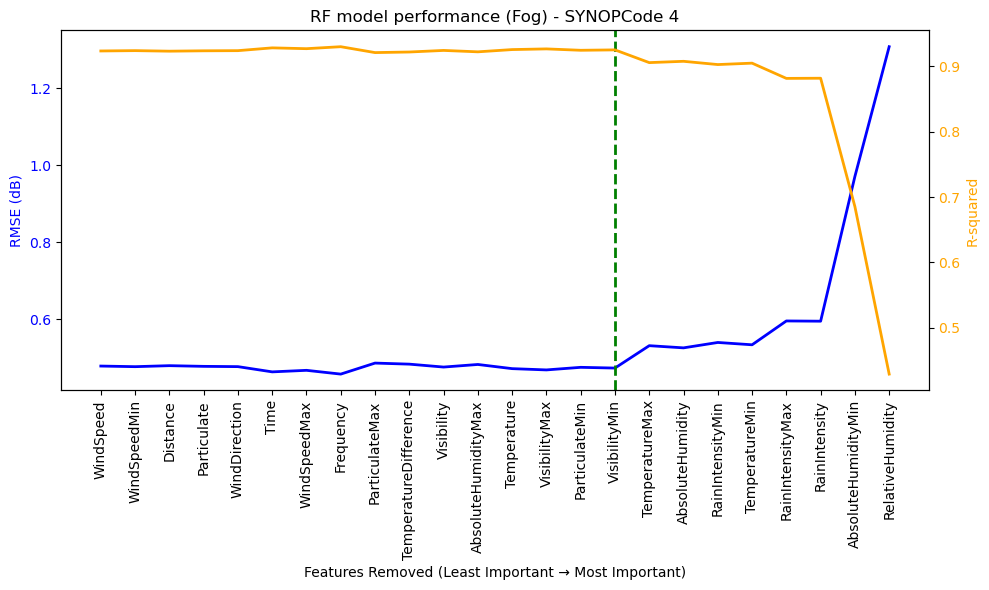

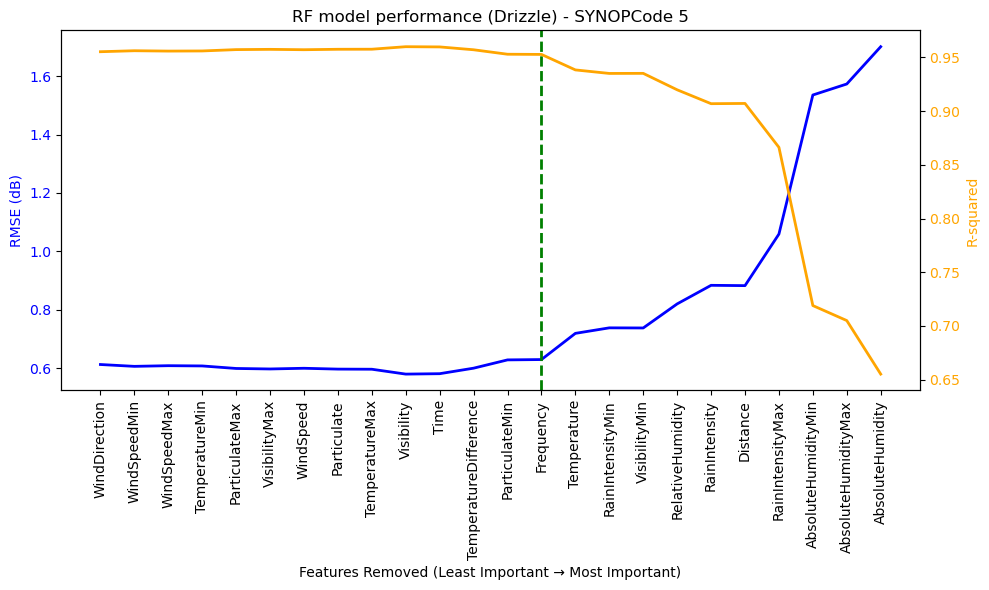

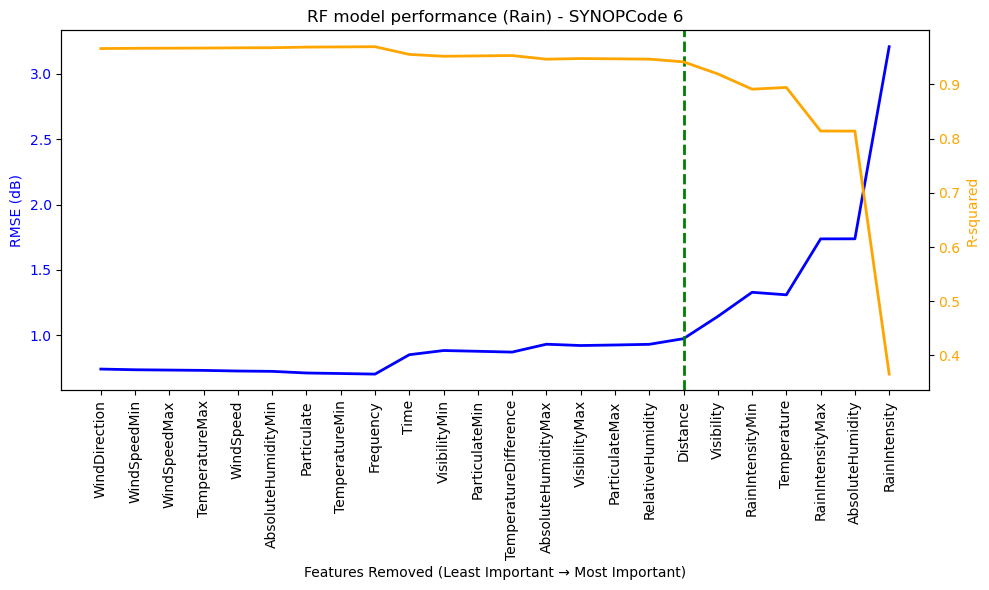

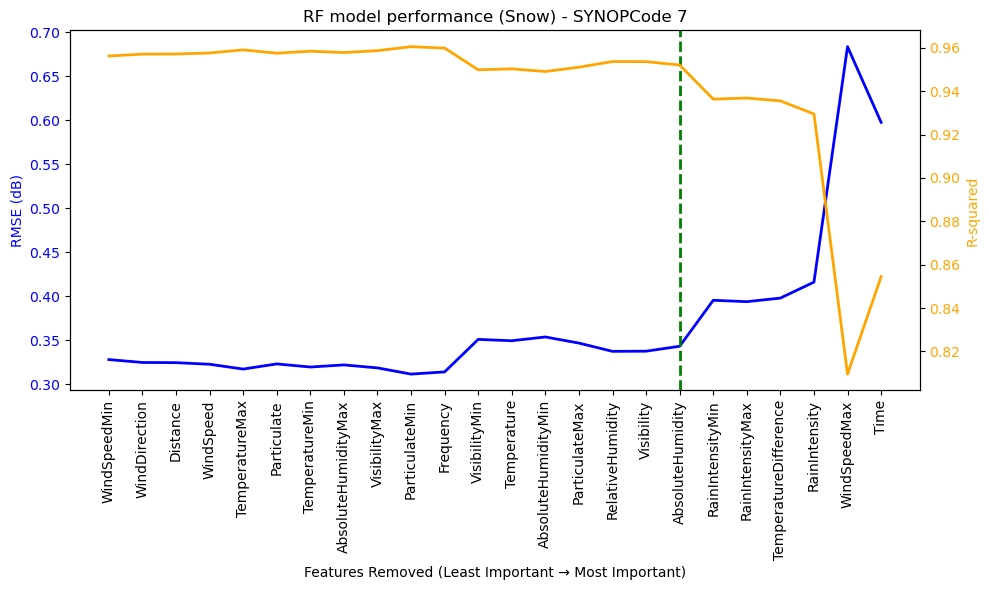

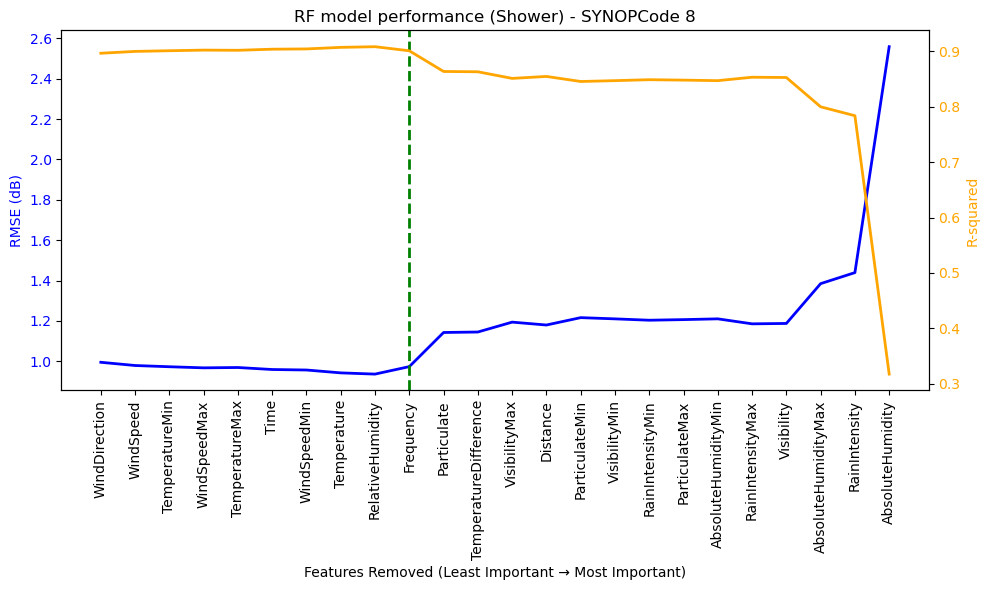

In [117]:
# Feature Elemination Plot with stop feature shown as the green line

stop_features = {
    0: 'Time',        # Replace with actual feature name for SYNOPCode 0
    3: 'TemperatureDifference',
    4: 'VisibilityMin',  # Replace with actual feature name for SYNOPCode 4
    5: 'Frequency',        # Replace with actual feature name for SYNOPCode 5
    6: 'Distance',   # Replace with actual feature name for SYNOPCode 6
    7: 'AbsoluteHumidity',   # Replace with actual feature name for SYNOPCode 7
    8: 'Frequency'  # Replace with actual feature name for SYNOPCode 8
}

# Corrected loop to extract the synop_code from the RFL_histories dictionary
for key, history in RFL_histories.items():
    # Extract synop_code by splitting the key (assuming the key format is 'RFL_SYNOPCode_X_history')
    synop_code = int(key.split('_')[2])  # Extract the number (e.g., 0, 3, 4, etc.)

    # Call your plotting function with the extracted synop_code and stop feature
    plot_feature_elimination(history, synop_code, stop_features[synop_code], 'RF')

In [118]:
# Review features_left, rmse, r2, remaining_features of each model after feature selection
RF_specific_details = get_details_after_stop_feature(RFL_histories, stop_features, 'RFL')
RF_specific_details

{'RFL_SYNOPCode_0_history': {'features_left': 9,
  'rmse': 0.46710571349425495,
  'r2': 0.9665430713660398,
  'remaining_features': ['AbsoluteHumidity',
   'AbsoluteHumidityMax',
   'AbsoluteHumidityMin',
   'Distance',
   'Frequency',
   'RelativeHumidity',
   'Temperature',
   'Visibility',
   'VisibilityMin']},
 'RFL_SYNOPCode_3_history': {'features_left': 8,
  'rmse': 0.5873390023412066,
  'r2': 0.9630879592100825,
  'remaining_features': ['AbsoluteHumidity',
   'AbsoluteHumidityMax',
   'AbsoluteHumidityMin',
   'RelativeHumidity',
   'Temperature',
   'TemperatureMax',
   'TemperatureMin',
   'Time']},
 'RFL_SYNOPCode_4_history': {'features_left': 8,
  'rmse': 0.5311062157037696,
  'r2': 0.9058930572618041,
  'remaining_features': ['AbsoluteHumidity',
   'AbsoluteHumidityMin',
   'RainIntensity',
   'RainIntensityMax',
   'RainIntensityMin',
   'RelativeHumidity',
   'TemperatureMax',
   'TemperatureMin']},
 'RFL_SYNOPCode_5_history': {'features_left': 10,
  'rmse': 0.71932453503

In [23]:
# Hyperparameter Tuning
synop_codes = [0, 3, 4, 5, 6, 7, 8]
best_rf_specific_models = hyperparameter_tuning_for_specific_models(RFL_X_train_groups, RFL_y_train_groups, stop_features, synop_codes, channel_name='RFL')

Hyperparameter tuning:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Hyperparameter tuning:  14%|█▍        | 1/7 [20:45<2:04:33, 1245.57s/it]

Best Model for SYNOPCode 0:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
OOB RMSE: 0.1628
OOB R^2: 0.9959
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  29%|██▊       | 2/7 [20:49<42:57, 515.43s/it]   

Best Model for SYNOPCode 3:
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
OOB RMSE: 0.2599
OOB R^2: 0.9928
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  43%|████▎     | 3/7 [20:57<18:53, 283.48s/it]

Best Model for SYNOPCode 4:
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
OOB RMSE: 0.1991
OOB R^2: 0.9868
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  57%|█████▋    | 4/7 [23:04<11:05, 221.93s/it]

Best Model for SYNOPCode 5:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.2551
OOB R^2: 0.9922
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Hyperparameter tuning:  71%|███████▏  | 5/7 [32:47<11:43, 351.98s/it]

Best Model for SYNOPCode 6:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3228
OOB R^2: 0.9936
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  86%|████████▌ | 6/7 [32:55<03:55, 235.05s/it]

Best Model for SYNOPCode 7:
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.1273
OOB R^2: 0.9934
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning: 100%|██████████| 7/7 [33:19<00:00, 285.65s/it]

Best Model for SYNOPCode 8:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
OOB RMSE: 0.3768
OOB R^2: 0.9852


In [139]:
# Model evaluation
rf_specific_rmse, rf_specific_r2, rf_specific_rmse_mean, rf_specific_r2_mean = evaluate_specific_models(best_rf_specific_models , RFL_X_test, RFL_y_test)

Model evaluation for SYNOPCode 0: RMSE = 0.2016, R^2 = 0.9937
Model evaluation for SYNOPCode 3: RMSE = 0.2849, R^2 = 0.9915
Model evaluation for SYNOPCode 4: RMSE = 0.2108, R^2 = 0.9826
Model evaluation for SYNOPCode 5: RMSE = 0.3774, R^2 = 0.9830
Model evaluation for SYNOPCode 6: RMSE = 0.4915, R^2 = 0.9849
Model evaluation for SYNOPCode 7: RMSE = 0.1932, R^2 = 0.9870
Model evaluation for SYNOPCode 8: RMSE = 0.5069, R^2 = 0.9727
Overall RMSE for all models: 0.3238
Overall R^2 for all models: 0.9851


#### 8.2 FSO Specific Model

In [12]:
# Feature Elemination For FSO Specific Model 
FSO_histories = {}
for code, X_group, y_group in zip([0, 3, 4, 5, 6, 7, 8], FSO_X_train_groups, FSO_y_train_groups):
    FSO_histories[f'FSO_SYNOPCode_{code}_history'] = iterative_feature_elimination(X_group, y_group, f'FSO_SYNOPCode_{code}')

Eliminating features for FSO_SYNOPCode_0:   0%|          | 0/24 [00:00<?, ?feature/s]

Eliminating features for FSO_SYNOPCode_8: 100%|██████████| 24/24 [00:07<00:00,  3.37feature/s]


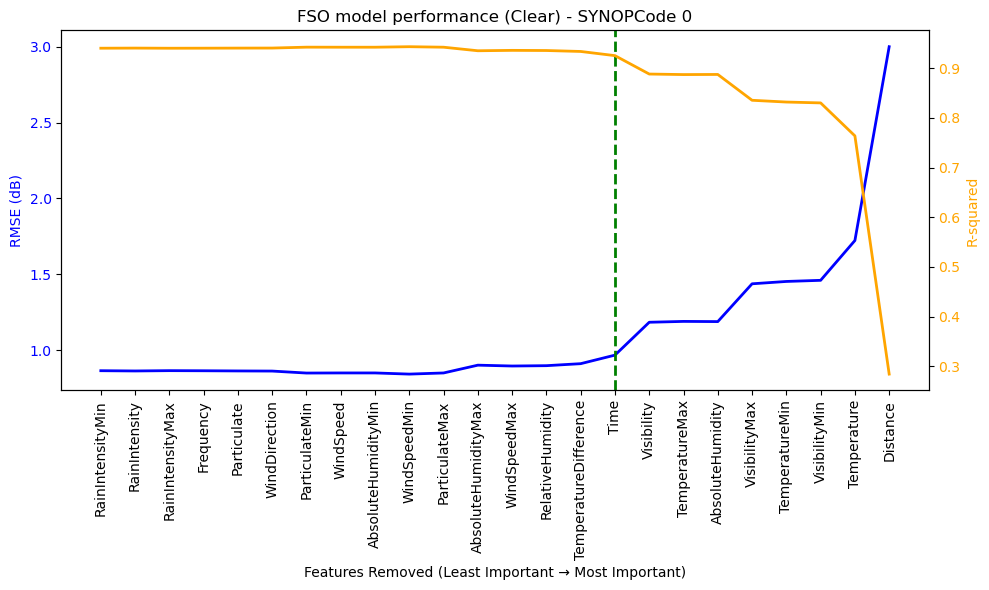

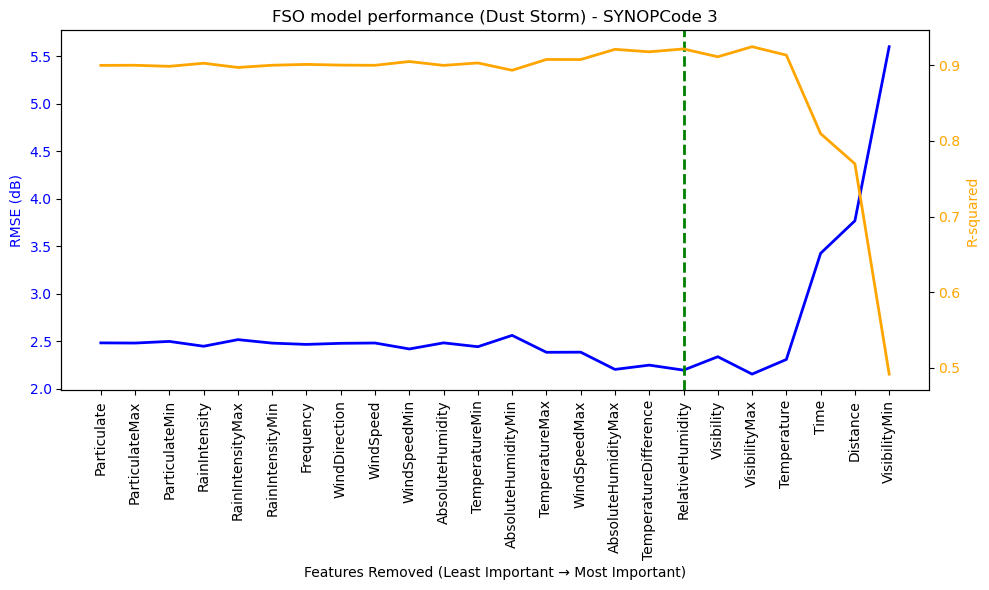

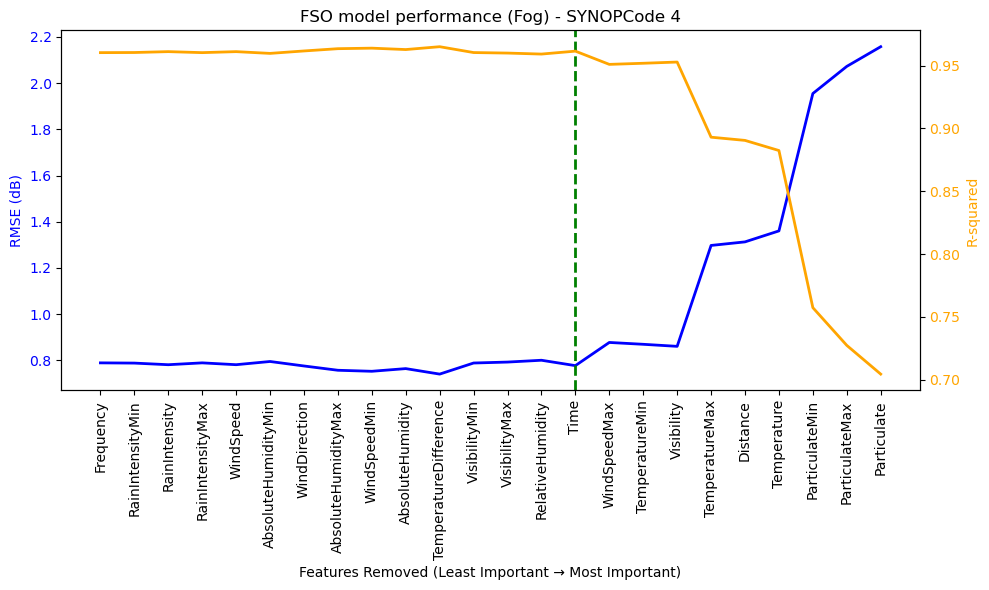

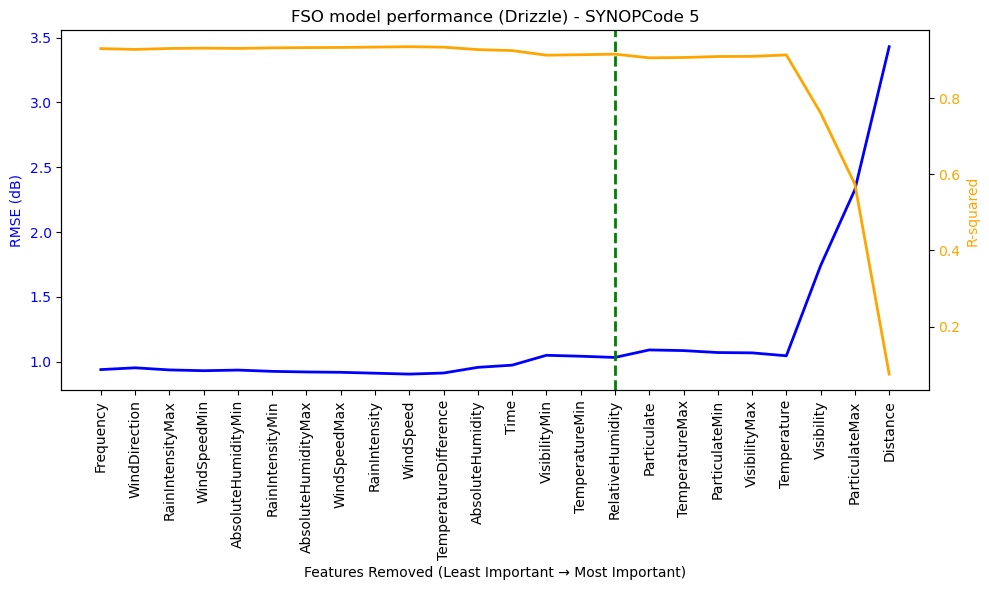

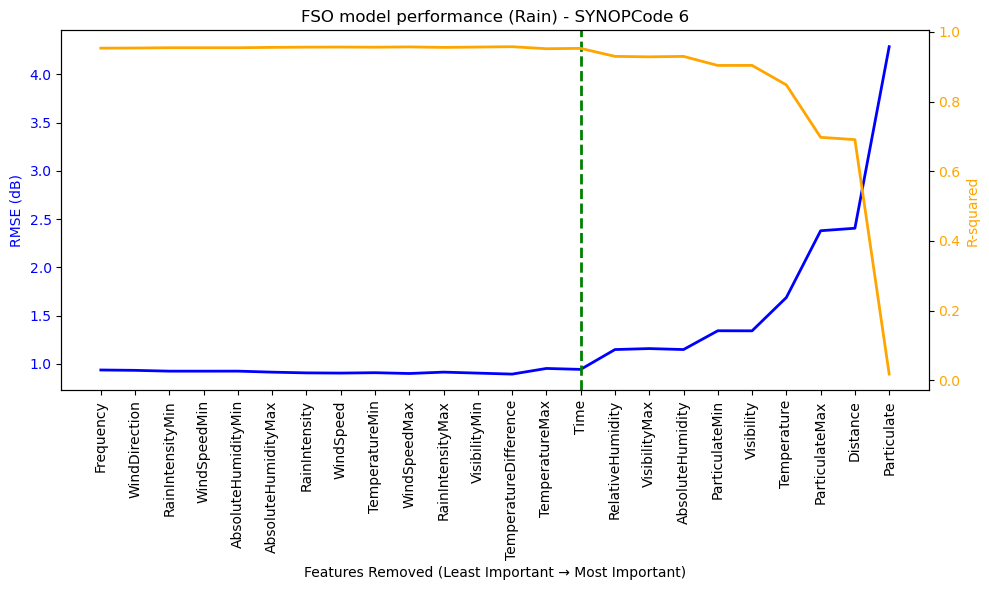

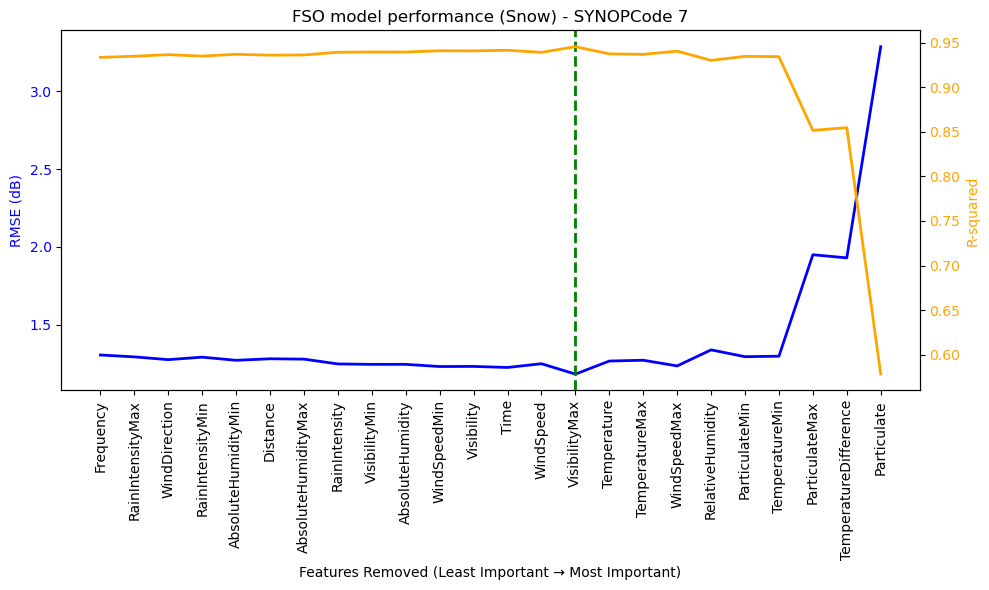

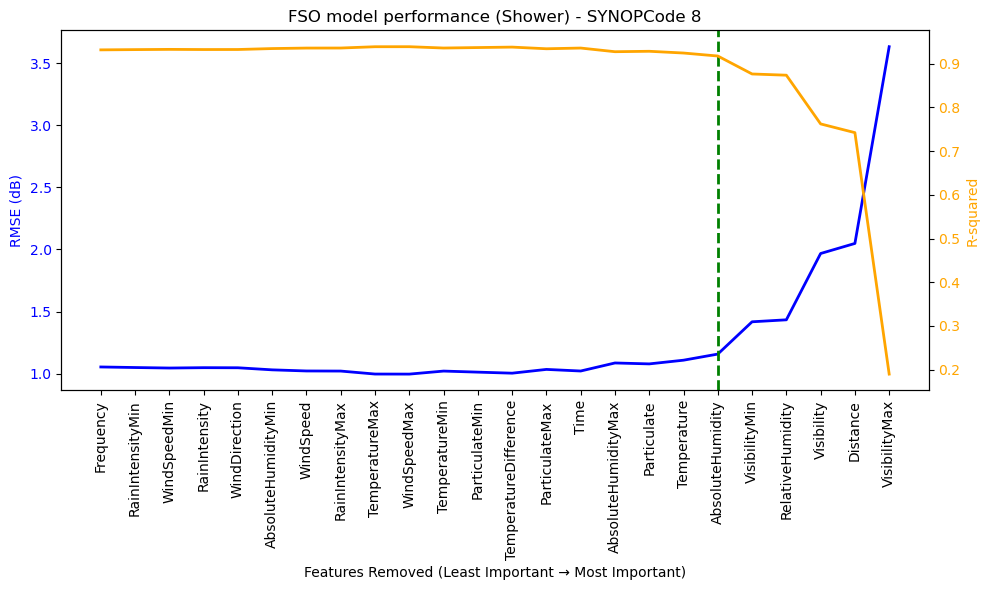

In [132]:
# Feature Elemination Plot with stop feature shown as the green line
FSO_stop_features = {
    0: 'Time',        
    3: 'RelativeHumidity',         
    4: 'Time',  
    5: 'RelativeHumidity',       
    6: 'Time',  
    7: 'VisibilityMax',  
    8: 'AbsoluteHumidity'  
}

# Corrected loop to extract the synop_code from the RFL_histories dictionary
for key, history in FSO_histories.items():
    # Extract synop_code by splitting the key (assuming the key format is 'RFL_SYNOPCode_X_history')
    synop_code = int(key.split('_')[2]) 

    # Call your plotting function with the extracted synop_code and stop feature
    plot_feature_elimination(history, synop_code, FSO_stop_features[synop_code], 'FSO')

In [133]:
# Review features_left, rmse, r2, remaining_features of each model after feature selection
FSO_details = get_details_after_stop_feature(FSO_histories, FSO_stop_features, 'FSO')
FSO_details

{'FSO_SYNOPCode_0_history': {'features_left': 8,
  'rmse': 1.1839195165977328,
  'r2': 0.8885245130827019,
  'remaining_features': ['AbsoluteHumidity',
   'Distance',
   'Temperature',
   'TemperatureMax',
   'TemperatureMin',
   'Visibility',
   'VisibilityMax',
   'VisibilityMin']},
 'FSO_SYNOPCode_3_history': {'features_left': 6,
  'rmse': 2.337802708207498,
  'r2': 0.9113632953228482,
  'remaining_features': ['Distance',
   'Temperature',
   'Time',
   'Visibility',
   'VisibilityMax',
   'VisibilityMin']},
 'FSO_SYNOPCode_4_history': {'features_left': 9,
  'rmse': 0.8777090358643349,
  'r2': 0.951056059971314,
  'remaining_features': ['Distance',
   'Particulate',
   'ParticulateMax',
   'ParticulateMin',
   'Temperature',
   'TemperatureMax',
   'TemperatureMin',
   'Visibility',
   'WindSpeedMax']},
 'FSO_SYNOPCode_5_history': {'features_left': 8,
  'rmse': 1.0906600158139,
  'r2': 0.906433300045776,
  'remaining_features': ['Distance',
   'Particulate',
   'ParticulateMax',
   

In [79]:
# Hyperparameter Tuning
synop_codes = [0, 3, 4, 5, 6, 7, 8]
best_fso_specific_models = hyperparameter_tuning_for_specific_models(FSO_X_train_groups, FSO_y_train_groups, FSO_stop_features, synop_codes, channel_name='FSO')

Hyperparameter tuning:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Hyperparameter tuning:  14%|█▍        | 1/7 [19:03<1:54:20, 1143.34s/it]

Best Model for SYNOPCode 0:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3557
OOB R^2: 0.9899
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  29%|██▊       | 2/7 [19:08<39:29, 473.81s/it]   

Best Model for SYNOPCode 3:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.8706
OOB R^2: 0.9877
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  43%|████▎     | 3/7 [19:16<17:25, 261.29s/it]

Best Model for SYNOPCode 4:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3146
OOB R^2: 0.9937
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  57%|█████▋    | 4/7 [20:58<09:55, 198.44s/it]

Best Model for SYNOPCode 5:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3494
OOB R^2: 0.9904
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  71%|███████▏  | 5/7 [29:14<10:10, 305.48s/it]

Best Model for SYNOPCode 6:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
OOB RMSE: 0.3847
OOB R^2: 0.9921
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning:  86%|████████▌ | 6/7 [29:20<03:23, 203.87s/it]

Best Model for SYNOPCode 7:
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
OOB RMSE: 0.5148
OOB R^2: 0.9896
Fitting 3 folds for each of 27 candidates, totalling 81 fits


Hyperparameter tuning: 100%|██████████| 7/7 [29:43<00:00, 254.81s/it]

Best Model for SYNOPCode 8:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3913
OOB R^2: 0.9906


In [80]:
# Model evaluation
fso_specific_rmse, fso_specific_r2, fso_specific_rmse_mean, fso_specific_r2_mean = evaluate_specific_models(
    models=best_fso_specific_models, 
    X_test=FSO_X_test, 
    y_test=FSO_y_test
)

Model evaluation for SYNOPCode 0: RMSE = 0.9342, R^2 = 0.9272
Model evaluation for SYNOPCode 3: RMSE = 1.6979, R^2 = 0.9628
Model evaluation for SYNOPCode 4: RMSE = 0.7540, R^2 = 0.9623
Model evaluation for SYNOPCode 5: RMSE = 1.0005, R^2 = 0.9231
Model evaluation for SYNOPCode 6: RMSE = 1.0009, R^2 = 0.9452
Model evaluation for SYNOPCode 7: RMSE = 1.3226, R^2 = 0.9479
Model evaluation for SYNOPCode 8: RMSE = 0.8415, R^2 = 0.9517
Overall RMSE for all models: 1.0788
Overall R^2 for all models: 0.9457


#### 8.3 RF Generic Model

In [69]:
# Feature Elemination For RF Generic Model 
RFL_generic_histories = {}
RFL_generic_histories = iterative_feature_elimination(RFL_X_train_generic, RFL_y_train_generic, 'RFL Generic Model')

Eliminating features for RFL Generic Model: 100%|██████████| 30/30 [13:38<00:00, 27.30s/feature]


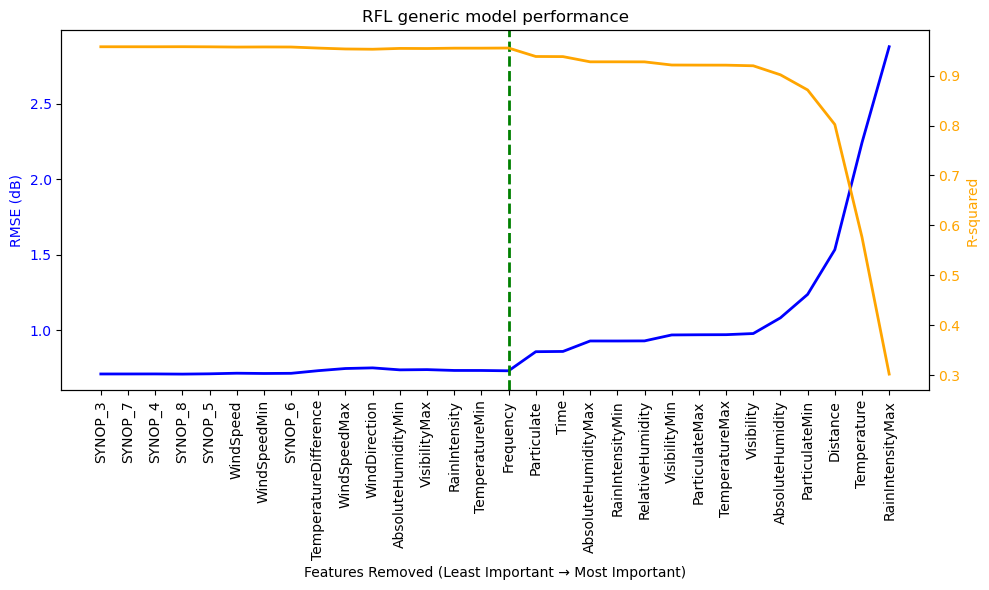

In [13]:
#Feature Elemination Plot with stop feature shown as the green line
plot_feature_elimination_generic(RFL_generic_histories, 'Frequency', 'RFL')

In [15]:
# Review features_left, rmse, r2, remaining_features of each model after feature selection
RF_generic_result = get_details_after_stop_feature_generic(RFL_generic_histories, stop_feature = 'Frequency')
RF_generic_result


{'features_left': 14,
 'rmse': 0.8569808761053118,
 'r2': 0.9381012800524838,
 'remaining_features': ['AbsoluteHumidity',
  'AbsoluteHumidityMax',
  'Distance',
  'Particulate',
  'ParticulateMax',
  'ParticulateMin',
  'RainIntensityMax',
  'RainIntensityMin',
  'RelativeHumidity',
  'Temperature',
  'TemperatureMax',
  'Time',
  'Visibility',
  'VisibilityMin']}

In [19]:
# Hyperparameter Tuning
RF_remaining_features = RF_generic_result['remaining_features']
RF_generic_history = hyperparameter_tuning_generic_model(RFL_X_train_generic, RFL_y_train_generic, RF_remaining_features , 'RF')


['AbsoluteHumidity', 'AbsoluteHumidityMax', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'Temperature', 'TemperatureMax', 'Time', 'Visibility', 'VisibilityMin']


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Model:
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3668
OOB R^2: 0.9886


In [22]:
# Model Evaluation

# Load the model from the saved file
best_rf_generic_model = joblib.load('RF_best_model.pkl')
synop_columns = ['SYNOP_3', 'SYNOP_4', 'SYNOP_5', 'SYNOP_6', 'SYNOP_7', 'SYNOP_8']  # Example column names

# Call the evaluation function with the test data (X_test, y_test), the model, and the history
rf_generic_results = evaluate_generic_model(best_rf_generic_model, RFL_X_test_generic,RFL_y_test_generic, synop_columns, RF_remaining_features)


SYNOP_0: RMSE = 0.5823, R^2 = 0.9480
SYNOP_3: RMSE = 0.4302, R^2 = 0.9783
SYNOP_4: RMSE = 0.5977, R^2 = 0.8301
SYNOP_5: RMSE = 0.8150, R^2 = 0.9206
SYNOP_6: RMSE = 1.1950, R^2 = 0.9138
SYNOP_7: RMSE = 0.6141, R^2 = 0.8451
SYNOP_8: RMSE = 1.1829, R^2 = 0.8363
Overall: RMSE = 0.8250, R^2 = 0.9428


#### 8.4 FSO Generic Model

In [91]:
# Feature Elemination For FSO Generic Model 
FSO_generic_histories = {}
FSO_generic_histories = iterative_feature_elimination(FSO_X_train_generic, FSO_y_train_generic, 'FSO Generic Model')

Eliminating features for FSO Generic Model: 100%|██████████| 30/30 [15:54<00:00, 31.81s/feature]


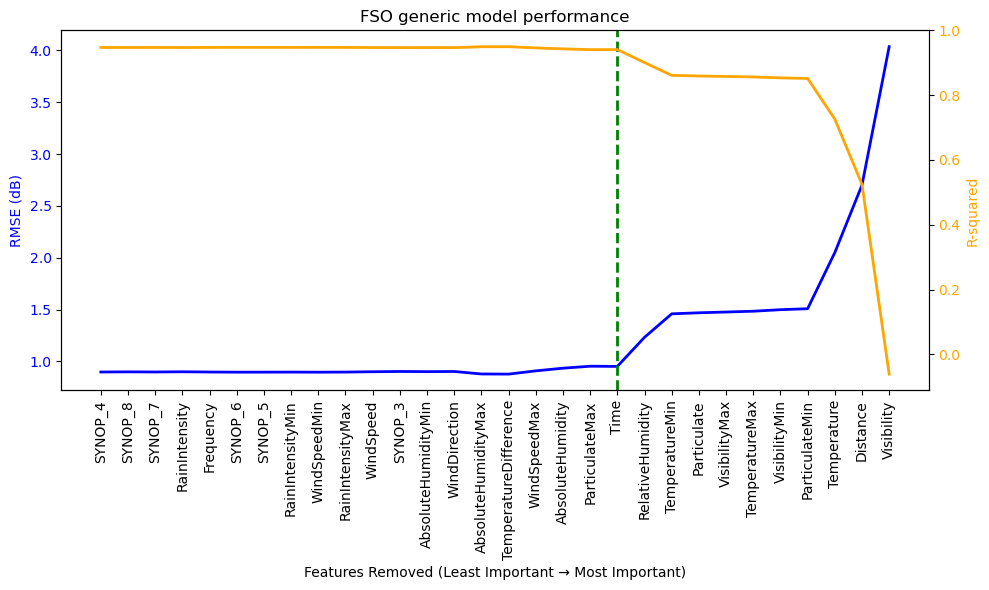

In [120]:
#Feature Elemination Plot with stop feature shown as the green line
plot_feature_elimination_generic(FSO_generic_histories, 'Time', 'FSO')

In [121]:
# Review features_left, rmse, r2, remaining_features of each model after feature selection
FSO_generic_result = get_details_after_stop_feature_generic(FSO_generic_histories, stop_feature = 'Time')
FSO_generic_result

{'features_left': 10,
 'rmse': 1.233268999535166,
 'r2': 0.9009502991794966,
 'remaining_features': ['Distance',
  'Particulate',
  'ParticulateMin',
  'RelativeHumidity',
  'Temperature',
  'TemperatureMax',
  'TemperatureMin',
  'Visibility',
  'VisibilityMax',
  'VisibilityMin']}

In [122]:
# Hyperparameter Tuning
FSO_selected_features = FSO_generic_result['remaining_features']
FSO_generic_history = hyperparameter_tuning_generic_model(FSO_X_train_generic, FSO_y_train_generic,FSO_selected_features , 'FSO')

Grid Search for best model:   0%|          | 0/27 [00:00<?, ?it/s]/Users/oliviachan/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Grid Search for best model:   0%|          | 0/27 [12:29<?, ?it/s]


Best Model:
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
OOB RMSE: 0.3282
OOB R^2: 0.9930


In [55]:
# Model Evaluation
best_fso_generic_model = joblib.load('FSO_best_model.pkl')

synop_columns = ['SYNOP_3', 'SYNOP_4', 'SYNOP_5', 'SYNOP_6', 'SYNOP_7', 'SYNOP_8']  # Example column names

# Call the evaluation function with the test data (X_test, y_test), the model, and the history
fso_generic_results = evaluate_generic_model(
    best_fso_generic_model, FSO_X_test_generic, FSO_y_test_generic, synop_columns, FSO_selected_features)



SYNOP_0: RMSE = 0.5391, R^2 = 0.9765
SYNOP_3: RMSE = 0.9411, R^2 = 0.9846
SYNOP_4: RMSE = 0.6899, R^2 = 0.9713
SYNOP_5: RMSE = 0.5624, R^2 = 0.9758
SYNOP_6: RMSE = 0.5449, R^2 = 0.9844
SYNOP_7: RMSE = 0.9565, R^2 = 0.9699
SYNOP_8: RMSE = 0.6345, R^2 = 0.9725
Overall: RMSE = 0.5490, R^2 = 0.9804


### 9. Comparing results among models

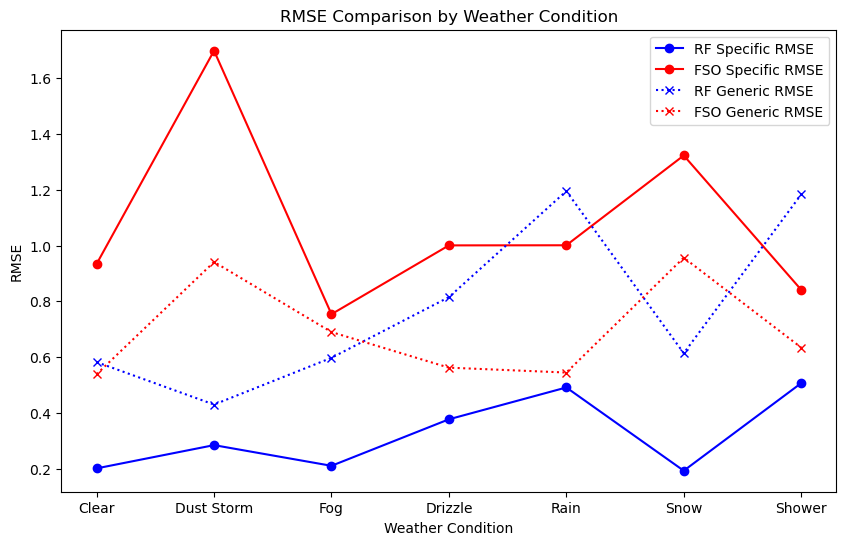

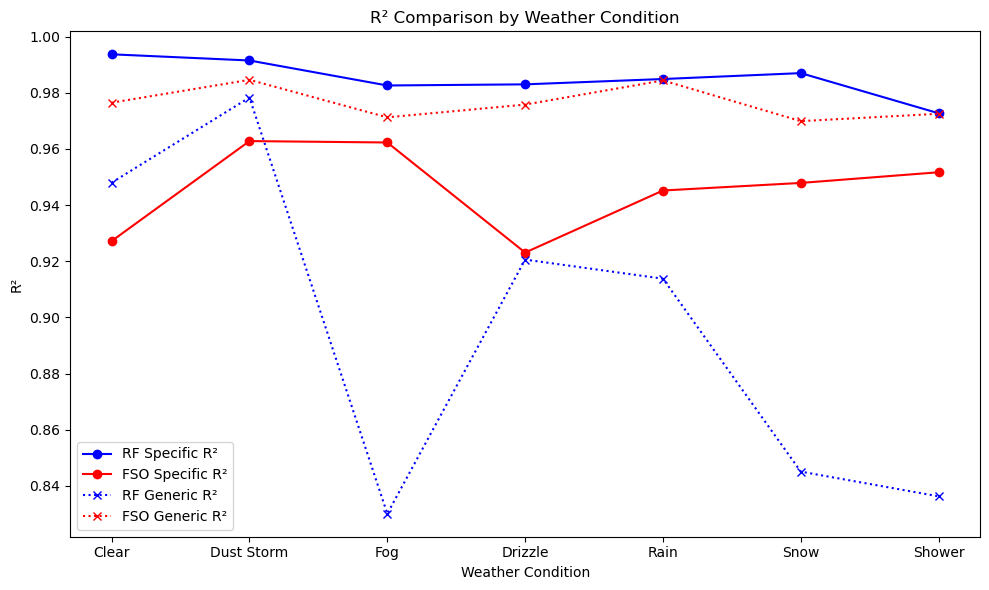

In [88]:
# Define the weather conditions
weather_conditions = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Shower'
}

# Call the function with provided data
plot_rmse_rsq_comparison(
    weather_conditions,
    rf_specific_rmse,
    rf_specific_r2,
    fso_specific_rmse,
    fso_specific_r2,
    rf_generic_results,
    fso_generic_results
)